In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import torch
from gmmot import wasserstein_gaussian, compute_optimal_coupling, compute_interpolated_gmm, transport_gmm_rand, transport_gmm_mean, transport_gmm_mode, fit_and_transport
from utils import generate_half_moons, plot_two_distrib, sample_GMM, plot_transport, plot_gmm_2d, imshow
from models import VAE_MNIST, Autoencoder_MNIST
from PIL import Image

## Basic functions and barycenters on 2D distributions

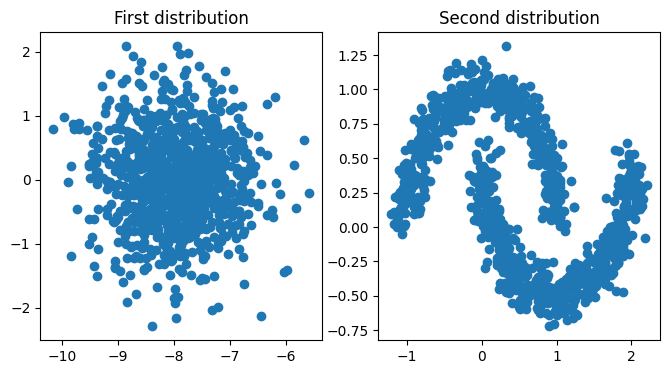

In [25]:
offset = np.array([-8, 0])

# mu=np.array([[0, 0], [3, 3]]) + offset
mu=np.array([[0, 0], [0, 0]]) + offset
Sigma=[np.diag([0.5, 0.5]), np.diag([0.5, 0.5])]

mu_2 = np.array([[2, 2], [1, 5]])
Sigma_2 = [np.diag([0.5, 0.5]), np.diag([0.5, 0.5])]

# plot the two distributions next to each other
X_1 = sample_GMM(mu=mu, Sigma=Sigma, alpha=np.array([0.5, 0.5]), n_samples=1000)
X_2 = generate_half_moons(1000)

# X_2 = sample_GMM(mu=mu_2, Sigma=Sigma_2, alpha=np.array([0.5, 0.5]), n_samples=1000)

plot_two_distrib(X_1, X_2)

In [26]:
# fit a GMM to the data
n_comp_1 = 6
n_comp_2 = 6
gmm_1 = GaussianMixture(n_components=n_comp_1)
gmm_2 = GaussianMixture(n_components=n_comp_2)

gmm_1.fit(X_1)
# print('First distribution :\n mean =', gmm_1.means_, '\n covariance =', gmm_1.covariances_)

gmm_2.fit(X_2)
# print('Second distribution :\n mean =', gmm_2.means_, '\n covariance =', gmm_2.covariances_)


GaussianMixture(n_components=6)

In [27]:
means0 = gmm_1.means_
covs0 = gmm_1.covariances_
weights0 = gmm_1.weights_   

means1 = gmm_2.means_
covs1 = gmm_2.covariances_
weights1 = gmm_2.weights_

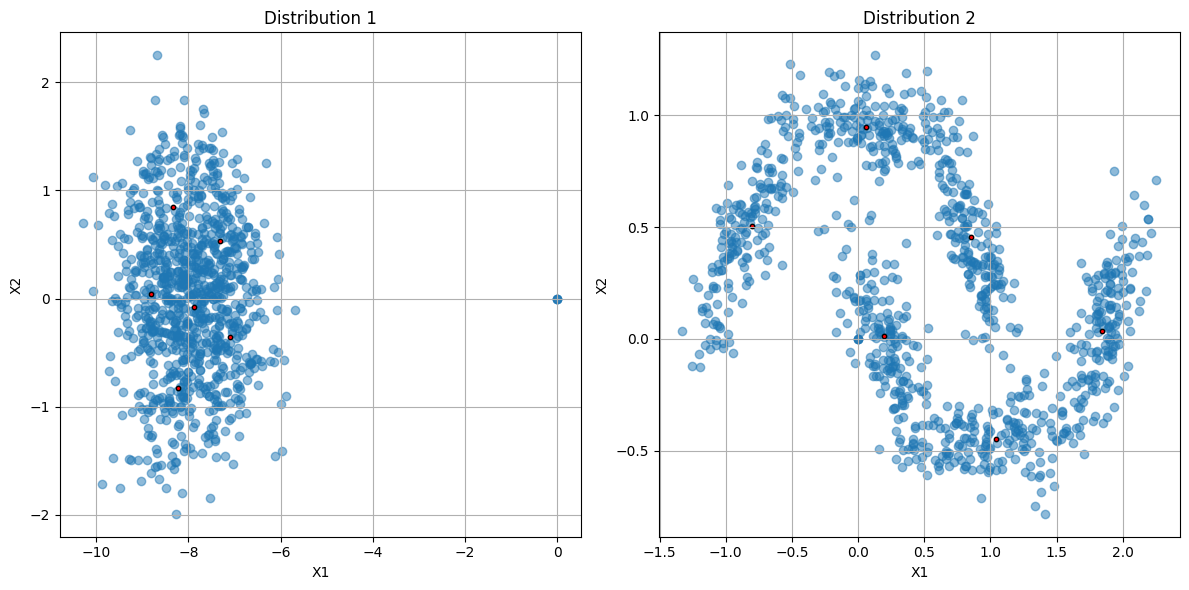

In [28]:
# Plot the two distributions using plot_gmm_2d
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_gmm_2d(means0, covs0, weights0, xlim=None, ylim=None, ax=axs[0], n_samples=1000)
axs[0].set_title('Distribution 1')

plot_gmm_2d(means1, covs1, weights1, xlim=None, ylim=None, ax=axs[1], n_samples=1000)
axs[1].set_title('Distribution 2')

plt.tight_layout()
plt.show()

In [29]:
# Compute optimal transport plan w*
w_star, C = compute_optimal_coupling(means0, covs0, weights0, means1, covs1, weights1)

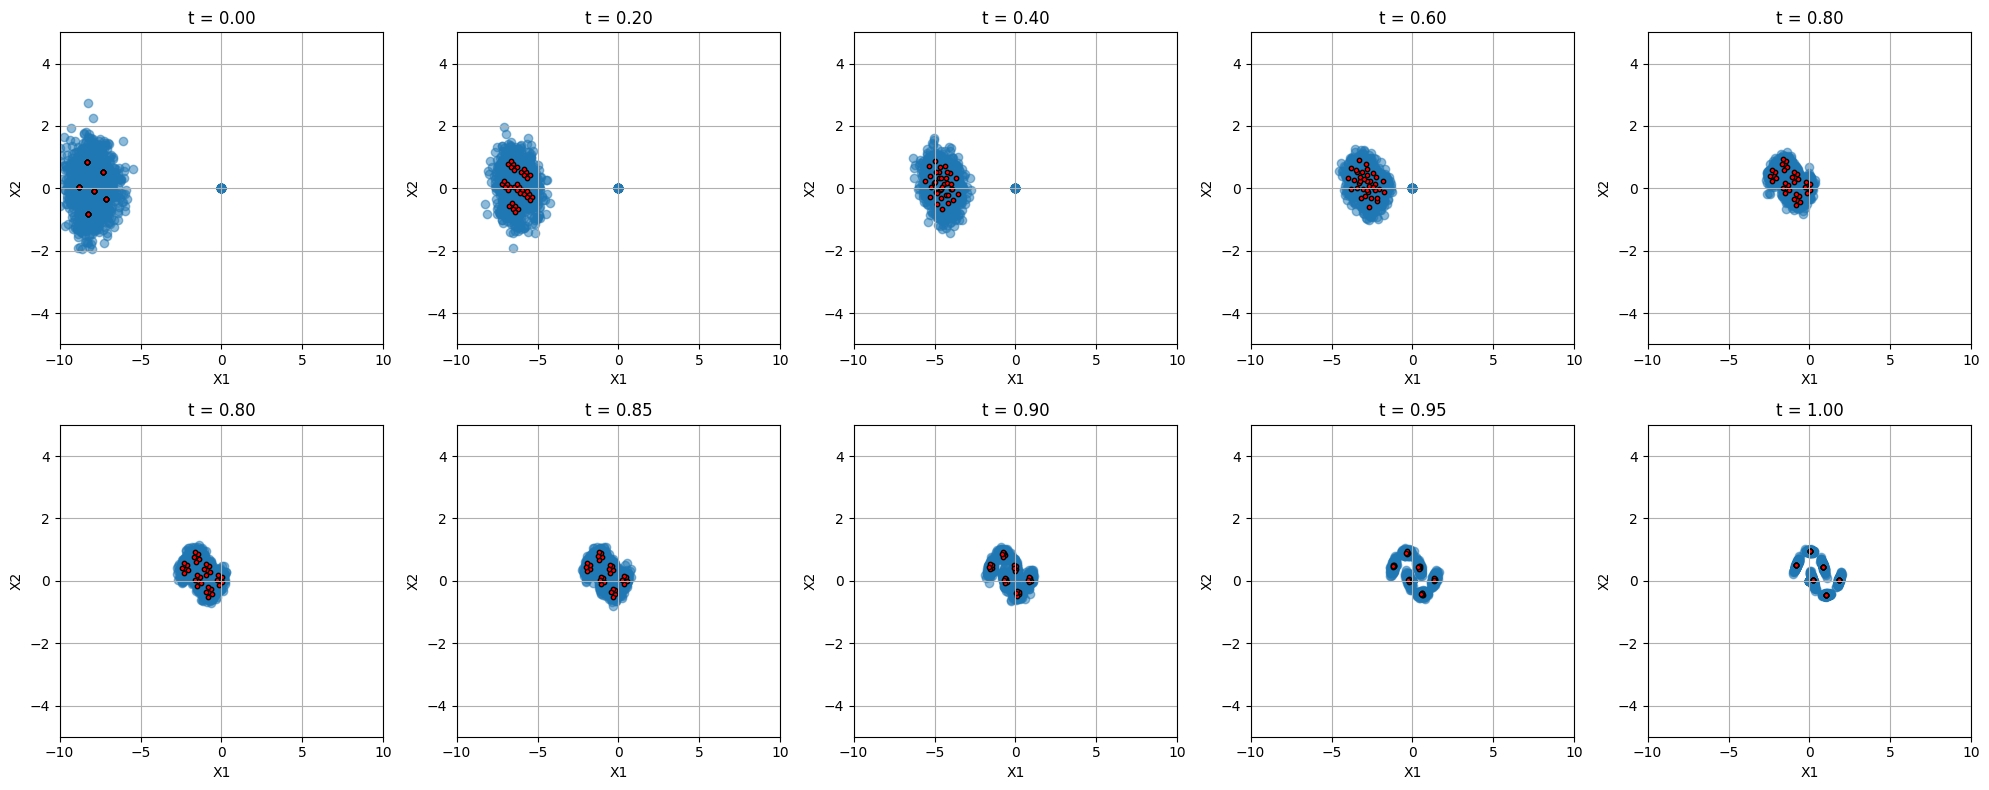

In [30]:
t = np.linspace(0, 0.8, 5)
t_prime = np.linspace(0.8, 1, 5)
t = np.concatenate((t, t_prime))
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flatten()):
    interpolated_means, interpolated_covs, interpolated_weights = compute_interpolated_gmm(means0, covs0, weights0, means1, covs1, weights1, w_star, t[i])
    plot_gmm_2d(interpolated_means, interpolated_covs, interpolated_weights, xlim=[-10, 10], ylim=[-5, 5], ax=ax, n_samples=1000)
    ax.set_title(f't = {t[i]:.2f}')
plt.tight_layout()
plt.show()

In [34]:
# Apply transport map to the first distribution
X_transported_rand = transport_gmm_rand(means0, covs0, weights0, means1, covs1, weights1, w_star, X_1)
X_transported_mean = transport_gmm_mean(means0, covs0, weights0, means1, covs1, weights1, w_star, X_1)
X_transported_mode = transport_gmm_mode(means0, covs0, weights0, means1, covs1, weights1, w_star, X_1)

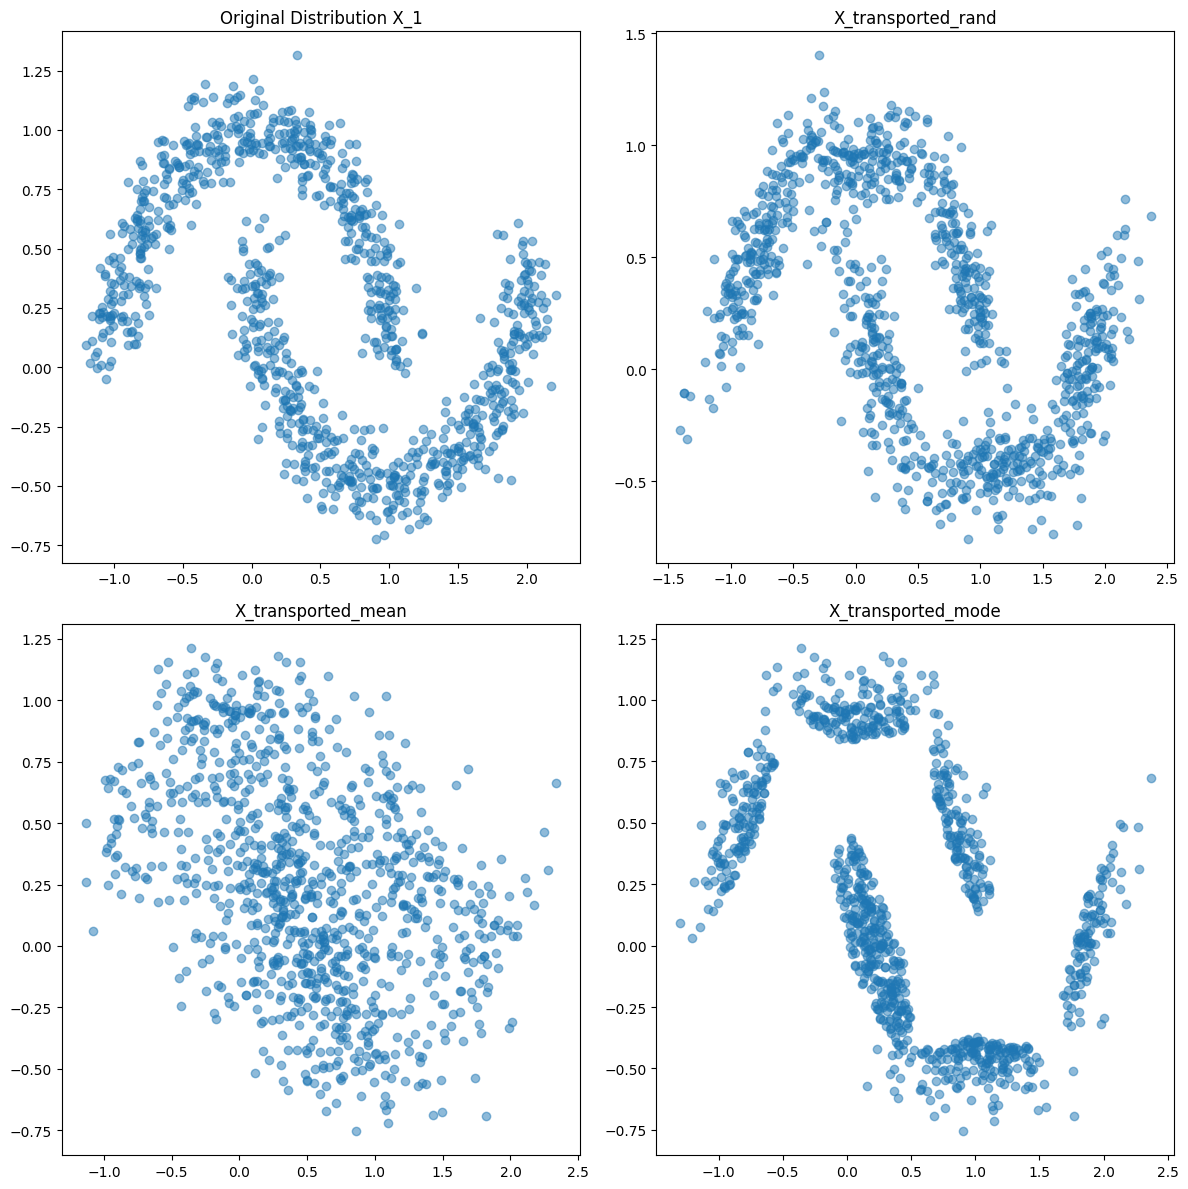

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot original distribution X_1
axs[0, 0].scatter(X_2[:, 0], X_2[:, 1], alpha=0.5, label='X_1')
axs[0, 0].set_title('Original Distribution X_1')

# X_transported_rand
axs[0, 1].scatter(X_transported_rand[:, 0], X_transported_rand[:, 1], alpha=0.5, label='X_transported_rand')
axs[0, 1].set_title('X_transported_rand')

# X_transported_mean
axs[1, 0].scatter(X_transported_mean[:, 0], X_transported_mean[:, 1], alpha=0.5, label='X_transported_mean')
axs[1, 0].set_title('X_transported_mean')

# X_transported_mode
axs[1, 1].scatter(X_transported_mode[:, 0], X_transported_mode[:, 1], alpha=0.5, label='X_transported_mode')
axs[1, 1].set_title('X_transported_mode')

plt.tight_layout()
plt.show()

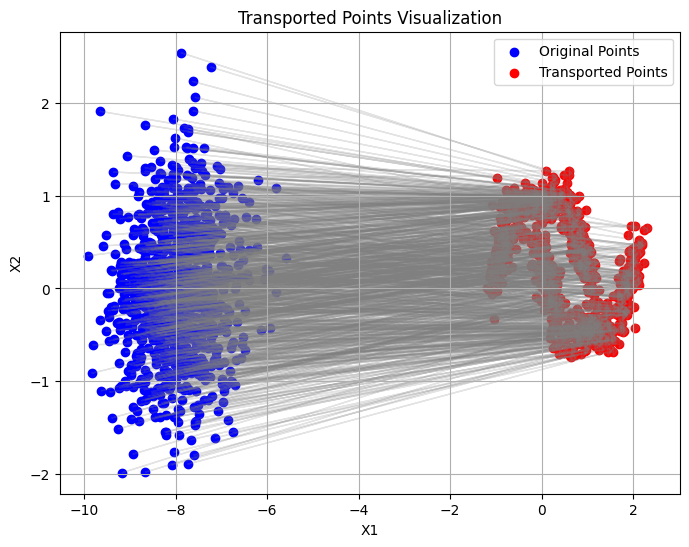

In [20]:
plot_transport(X_1, X_transported)

## Transporting 1 onto 6

In [12]:
vae_mnist = torch.load("../models/vae_mnist.pt")
vae = VAE_MNIST()
vae.load_state_dict(vae_mnist)

<All keys matched successfully>

In [13]:
autoencoder_mnist = torch.load("../models/autoencoder_mnist.pth")
autoencoder = Autoencoder_MNIST()
autoencoder.load_state_dict(autoencoder_mnist)

<All keys matched successfully>

In [6]:
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.utils.data as data

# the path is one folder up from the current directory
MNIST_path = '../'

batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(MNIST_path, train=True, transform=transform, download=False)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [18]:
# We get the embeddings of ones and sixes from the MNIST dataset

i = 0

for batch, labels in train_loader:
    ones = batch[labels==1]
    sixes = batch[labels==6]
    with torch.no_grad():
        if i==0:
            ones_latents_vae, _ = vae.encoder(ones)
            sixes_latents_vae, _ = vae.encoder(sixes)
            ones_latents_ae = autoencoder.encoder(ones)
            sixes_latents_ae = autoencoder.encoder(sixes)
        else:
            ones_latent_vae, _ = vae.encoder(ones)
            sixes_latent_vae, _ = vae.encoder(sixes)
            ones_latents_vae = np.concatenate((ones_latents_vae, ones_latent_vae), axis=0)
            sixes_latents_vae = np.concatenate((sixes_latents_vae, sixes_latent_vae), axis=0)
            ones_latent_ae = autoencoder.encoder(ones)
            sixes_latent_ae = autoencoder.encoder(sixes)
            ones_latents_ae = np.concatenate((ones_latents_ae, ones_latent_ae), axis=0)
            sixes_latents_ae = np.concatenate((sixes_latents_ae, sixes_latent_ae), axis=0)
    i+=1

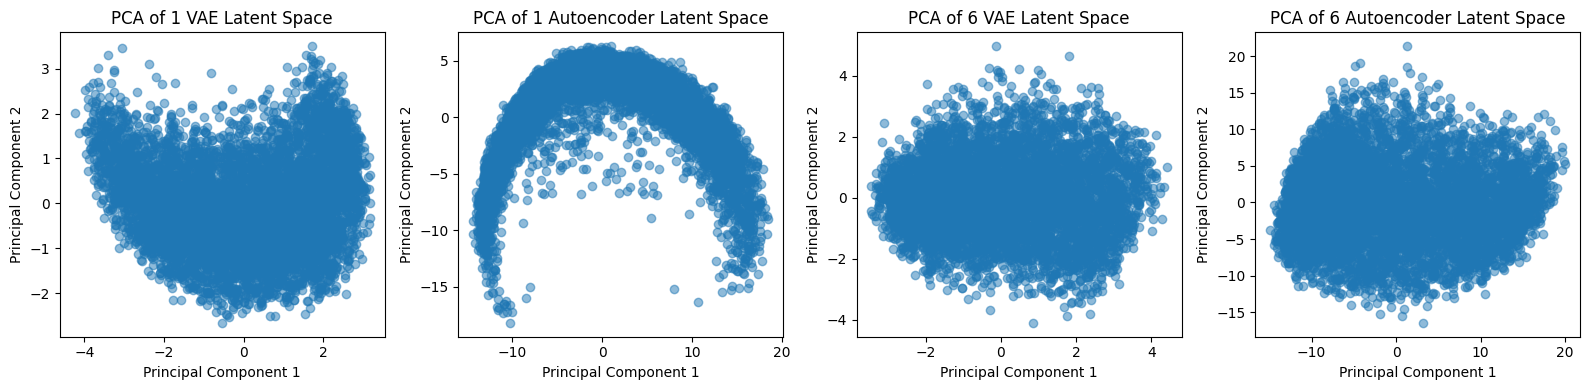

In [19]:
from sklearn.decomposition import PCA

# Perform PCA on the latent space of the VAE
pca_vae = PCA(n_components=2)
ones_latents_vae_pca = pca_vae.fit_transform(ones_latents_vae)
sixes_latents_vae_pca = pca_vae.fit_transform(sixes_latents_vae)

# Perform PCA on the latent space of the Autoencoder
pca_autoencoder = PCA(n_components=2)
ones_latents_ae_pca = pca_autoencoder.fit_transform(ones_latents_ae)
sixes_latents_ae_pca = pca_autoencoder.fit_transform(sixes_latents_ae)

# Plot the PCA results
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].scatter(ones_latents_vae_pca[:, 0], ones_latents_vae_pca[:, 1], alpha=0.5)
axes[0].set_title('PCA of 1 VAE Latent Space')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

axes[1].scatter(ones_latents_ae_pca[:, 0], ones_latents_ae_pca[:, 1], alpha=0.5)
axes[1].set_title('PCA of 1 Autoencoder Latent Space')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')

axes[2].scatter(sixes_latents_vae_pca[:, 0], sixes_latents_vae_pca[:, 1], alpha=0.5)
axes[2].set_title('PCA of 6 VAE Latent Space')
axes[2].set_xlabel('Principal Component 1')
axes[2].set_ylabel('Principal Component 2')

axes[3].scatter(sixes_latents_ae_pca[:, 0], sixes_latents_ae_pca[:, 1], alpha=0.5)
axes[3].set_title('PCA of 6 Autoencoder Latent Space')
axes[3].set_xlabel('Principal Component 1')
axes[3].set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()


In [20]:
X_1 = ones_latents_ae
X_2 = sixes_latents_ae

In [22]:
# Apply transport map to the first distribution
X_transported = fit_and_transport(X_1, X_2, n_comp_1=6, n_comp_2=6)

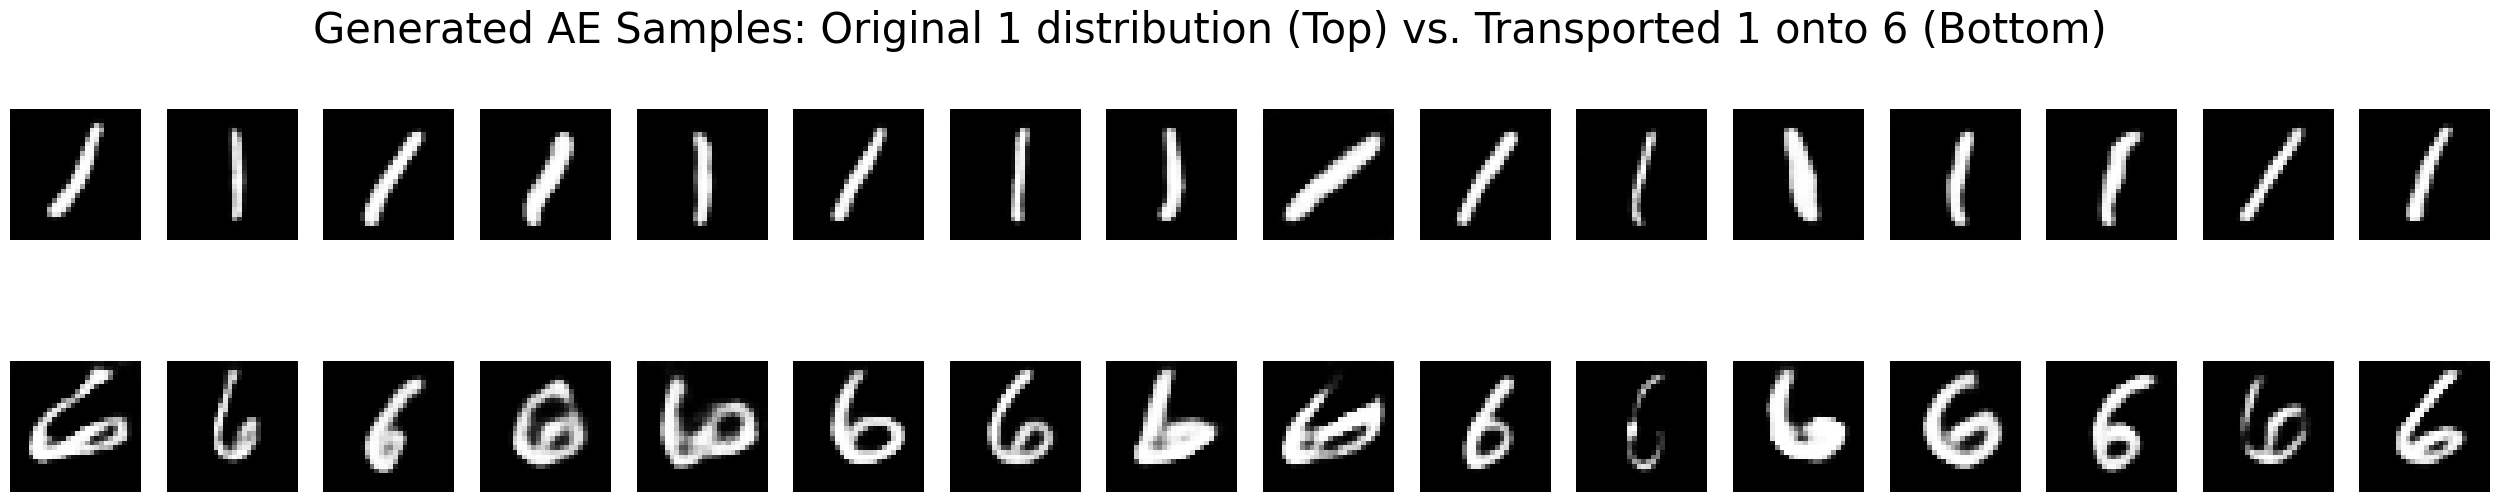

In [25]:
n_samples = 16

# Show samples from the WGAN and the VAE next to each other
with torch.no_grad():
    X_1_sample_tensor = torch.tensor(X_1[:n_samples], dtype=torch.float32)
    X_transported_sample_tensor = torch.tensor(X_transported[:n_samples], dtype=torch.float32)
    y_ae_1 = autoencoder.decoder(X_1_sample_tensor)
    y_ae_6 = autoencoder.decoder(X_transported_sample_tensor)

def show_samples(y_wgan, y_vae, num_samples=8):
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 6))

    for i in range(num_samples):
        # WGAN sample
        axes[0, i].imshow(y_wgan[i, 0].detach().cpu().numpy(), cmap='gray')
        axes[0, i].axis('off')

        # VAE sample
        axes[1, i].imshow(y_vae[i, 0].detach().cpu().numpy(), cmap='gray')
        axes[1, i].axis('off')

    plt.suptitle("Generated AE Samples: Original 1 distribution (Top) vs. Transported 1 onto 6 (Bottom)", fontsize=30)
    plt.show()

show_samples(y_ae_1, y_ae_6, num_samples=n_samples)

In [26]:
X_1 = ones_latents_vae
X_2 = sixes_latents_vae

In [27]:
# Apply transport map to the first distribution
X_transported = fit_and_transport(X_1, X_2, n_comp_1=6, n_comp_2=6)

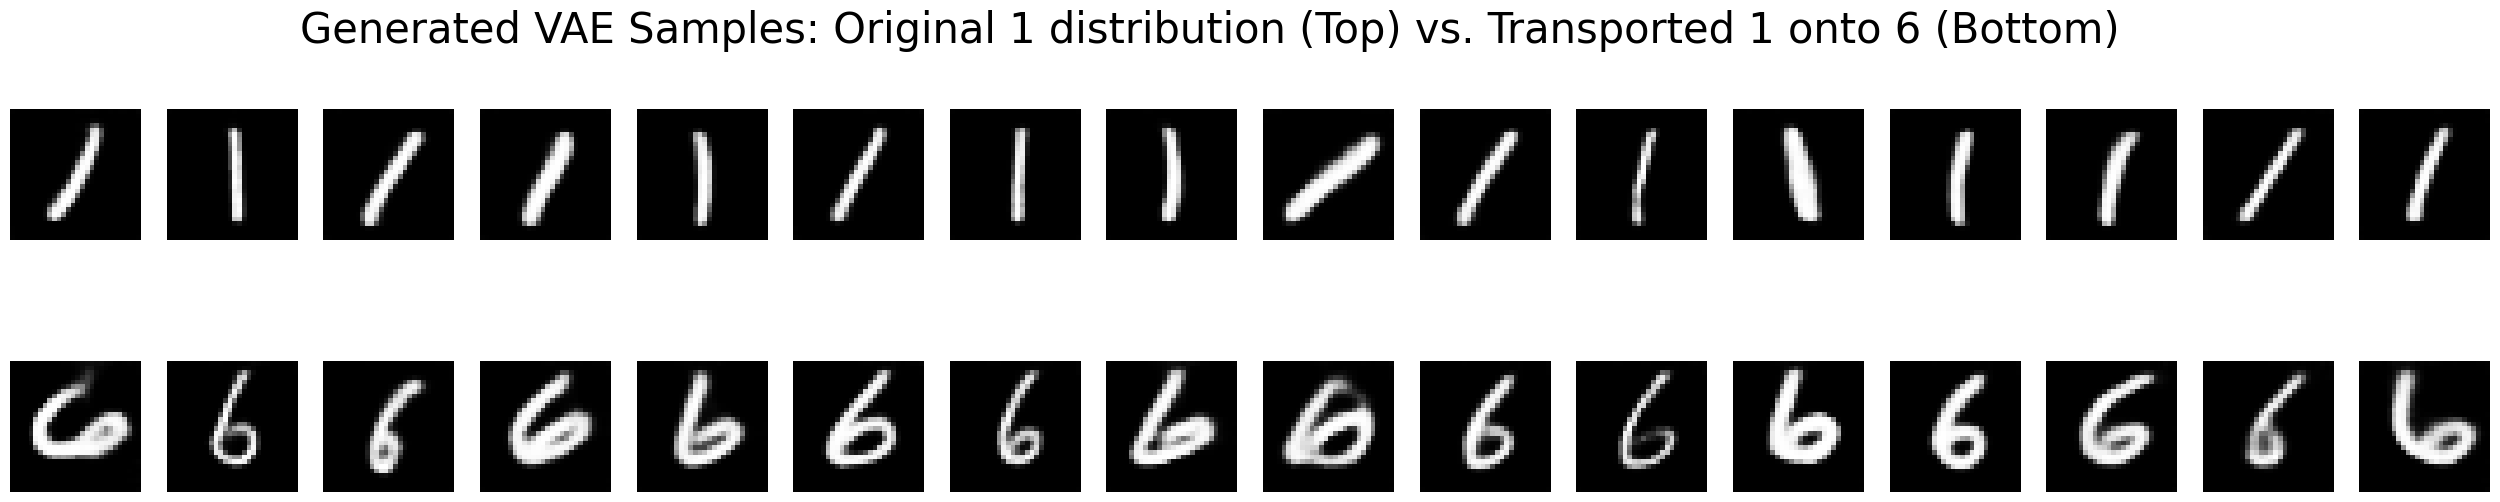

In [28]:
n_samples = 16

# Show samples from the WGAN and the VAE next to each other
with torch.no_grad():
    X_1_sample_tensor = torch.tensor(X_1[:n_samples], dtype=torch.float32)
    X_transported_sample_tensor = torch.tensor(X_transported[:n_samples], dtype=torch.float32)
    y_vae_1 = vae.decoder(X_1_sample_tensor)
    y_vae_6 = vae.decoder(X_transported_sample_tensor)

def show_samples(y_wgan, y_vae, num_samples=8):
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 6))

    for i in range(num_samples):
        # WGAN sample
        axes[0, i].imshow(y_wgan[i, 0].detach().cpu().numpy(), cmap='gray')
        axes[0, i].axis('off')

        # VAE sample
        axes[1, i].imshow(y_vae[i, 0].detach().cpu().numpy(), cmap='gray')
        axes[1, i].axis('off')

    plt.suptitle("Generated VAE Samples: Original 1 distribution (Top) vs. Transported 1 onto 6 (Bottom)", fontsize=30)
    plt.show()

show_samples(y_vae_1, y_vae_6, num_samples=n_samples)

## Color transfer

In [7]:
# Image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

im1 = Image.open("../images/SK-A-8.jpg")
im1 = transform(im1)
im1 = np.array(im1)

im2 = Image.open("../images/SK-A-29.jpg")
im2 = transform(im2)
im2 = np.array(im2)

im1 = im1[:, ::3, ::3,]
im2 = im2[:, ::3, ::3,]

im1_size_x, im1_size_y = im1.shape[1:]
im2_size_x, im2_size_y = im2.shape[1:]

im1 = im1.reshape(3, -1)
im2 = im2.reshape(3, -1)

/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_77904/3793286681.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im1 = np.array(im1)
/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_77904/3793286681.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im2 = np.array(im2)


In [35]:
X_1 = im1.T
X_2 = im2.T

In [36]:
# Apply transport map to the first distribution
X_transported_mean = fit_and_transport(X_1, X_2, n_comp_1=6, n_comp_2=6, method='mean')
X_transported_rand = fit_and_transport(X_1, X_2, n_comp_1=6, n_comp_2=6, method='rand')

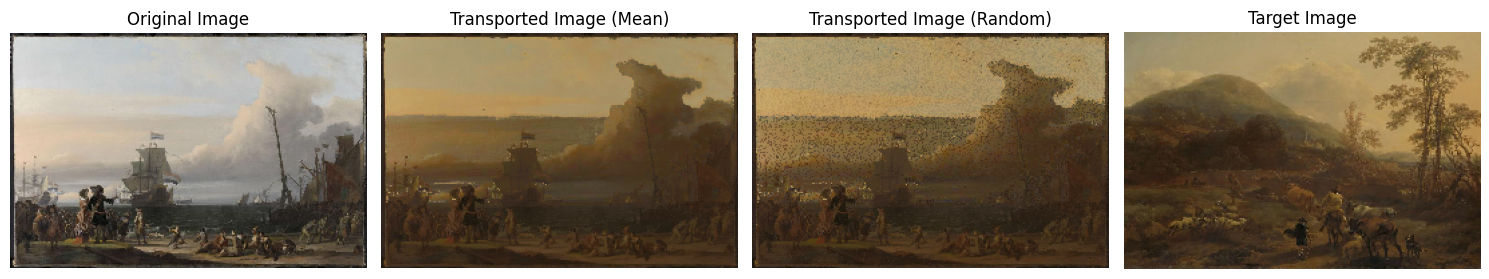

In [37]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Original image
X_r = X_1.T.reshape(3, im1_size_x, im1_size_y).T
X_r = np.transpose(X_r, (1, 0, 2))
axes[0].imshow(X_r)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Transported image
X_transported_mean_r = X_transported_mean.T.reshape(3, im1_size_x, im1_size_y).T
X_transported_mean_r = np.transpose(X_transported_mean_r, (1, 0, 2))
axes[1].imshow(X_transported_mean_r)
axes[1].set_title('Transported Image (Mean)')
axes[1].axis('off')

X_transported_rand_r = X_transported_rand.T.reshape(3, im1_size_x, im1_size_y).T
X_transported_rand_r = np.transpose(X_transported_rand_r, (1, 0, 2))
axes[2].imshow(X_transported_rand_r)
axes[2].set_title('Transported Image (Random)')
axes[2].axis('off')

# Target image
im2_r = im2.reshape(3, im2_size_x, im2_size_y).T
im2_r = np.transpose(im2_r, (1, 0, 2))
axes[3].imshow(im2_r)
axes[3].set_title('Target Image')
axes[3].axis('off')

plt.tight_layout()
plt.show()

## Transporting 1 onto 6 (directly)

In [8]:
# We get the ones and sixes from the MNIST dataset

i = 0

for batch, labels in train_loader:
    if i==0:
        ones = batch[labels==1]
        sixes = batch[labels==6]
    else : 
        one = batch[labels==1]
        six = batch[labels==6]
        ones = np.concatenate((ones, one), axis=0)
        sixes = np.concatenate((sixes, six), axis=0)
    i+=1
    

In [9]:
# Subsample each image to reduce computation time
ones_subsampled = ones[:, :, ::2, ::2]
sixes_subsampled = sixes[:, :, ::2, ::2]

In [40]:
size_x, size_y = ones_subsampled.shape[2:]

In [41]:
ones = ones.reshape(-1, 28*28)
sixes = sixes.reshape(-1, 28*28)

In [42]:
ones_subsampled = ones_subsampled.reshape(-1, size_x*size_y)
sixes_subsampled = sixes_subsampled.reshape(-1, size_x*size_y)

In [43]:
X_1 = ones
X_2 = sixes

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_1_scaled = scaler.fit_transform(X_1)
X_2_scaled = scaler.transform(X_2)

In [228]:
# fit a GMM to the data
n_comp_1 = 50
n_comp_2 = 50
gmm_1 = GaussianMixture(n_components=n_comp_1)
gmm_2 = GaussianMixture(n_components=n_comp_2)

gmm_1.fit(X_1)
# print('First distribution :\n mean =', gmm_1.means_, '\n covariance =', gmm_1.covariances_)

gmm_2.fit(X_2)
# print('Second distribution :\n mean =', gmm_2.means_, '\n covariance =', gmm_2.covariances_)

GaussianMixture(n_components=50)

In [ ]:
# Sample an image from the GMM and plot it
def sample_image(gmm, size_x, size_y):
    X_gen = gmm.sample(1)[0]
    X_gen = X_gen.reshape(size_x, size_y)
    plt.imshow(X_gen, cmap='gray')
    plt.axis('off')
    plt.show()

# sample_image(gmm_1, size_x, size_y)
sample_image(gmm_2, 28, 28)

ValueError: cannot reshape array of size 2 into shape (28,28)

In [184]:
means0 = gmm_1.means_
covs0 = gmm_1.covariances_
weights0 = gmm_1.weights_   

means1 = gmm_2.means_
covs1 = gmm_2.covariances_
weights1 = gmm_2.weights_

# Compute optimal transport plan w*
w_star, C = compute_optimal_coupling(means0, covs0, weights0, means1, covs1, weights1)

In [185]:
# Apply transport map to the first distribution
X_transported = transport_gmm_rand(means0, covs0, weights0, means1, covs1, weights1, w_star, X_1)
X_transported = X_transported

/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_multivariate.py:924: RuntimeWarning: overflow encountered in exp
  return np.exp(self.logpdf(x))
/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_42936/4246977350.py:81: RuntimeWarning: invalid value encountered in multiply
  probas[k, l] = w_star[k, l] * densities[k] / denum
/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_42936/4246977350.py:81: RuntimeWarning: invalid value encountered in divide
  probas[k, l] = w_star[k, l] * densities[k] / denum
/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_42936/4246977350.py:89: ComplexWarning: Casting complex values to real discards the imaginary part
  transports[k, l] = compute_transport_gaussian(means0[k], covs0[k], means1[l], covs1[l], X)


ValueError: Probabilities contain NaN

In [ ]:
X_1_r = X_1.reshape(-1, 28, 28)
X_transported_r = X_transported.reshape(-1, 28, 28)